# Single qubit GST on the 5 qubit chip (Data from 3.5.2023)

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [2]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
from pygsti.modelpacks import smq1Q_XYI as std
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt

%run ../src/mGST/reporting.py

### Setting the parameters

In [3]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 7  # maximum number of gates in each measurement sequence
d = 3  # number of gates
rK = 1   # rank of the model estimate
n_povm = 2   # number of POVM-elements

meas_samples = 1e4

### Loading data

In [4]:
with open('data/qw5q-qubit1-fast.json') as f:
    data = json.load(f)
print(data.keys())
J = np.array(data['sequences'])[:,::-1]
y = np.array(data['hardware_probabilities']).T

dict_keys(['nsequences', 'sequence_creation_time', 'execution_time', 'sequences', 'hardware_probabilities', 'platform', 'qubit', 'depth', 'nshots'])


In [7]:
print([1,*J.shape])

[1, 100, 7]


In [62]:
from argparse import Namespace
mGST_args = {'y': y, 'J': J, 'l': l, 'd': d, 'r': r, 'rK': rK, 'n_povm': n_povm, 'bsize': bsize, 
             'meas_samples': meas_samples, 'method': 'SFN', 'max_inits': 20, 'max_iter': 0, 
             'final_iter': 80, 'threshold_multiplier': 10, 'target_rel_prec': 1e-4}

def bootstrap_errors(K, X, E, rho, mGST_args, bootstrap_samples, weights, gate_labels, target_mdl, parametric = True):
    ns = Namespace(**mGST_args)
    if parametric:
        y = np.real(np.array([[E[i].conj()@low_level_jit.contract(X,j)@rho for j in J] for i in range(n_povm)]))
        y_sampled = additional_fns.sampled_measurements(y, meas_samples).copy()
    else: 
        y = ns.y
        y_sampled = additional_fns.sampled_measurements(y, meas_samples).copy()

    X_array = np.zeros((bootstrap_samples, *X.shape)).astype(complex)
    E_array = np.zeros((bootstrap_samples, *E.shape)).astype(complex)
    rho_array = np.zeros((bootstrap_samples, *rho.shape)).astype(complex)
    df_g_list = []
    df_o_list = []
    for i in range(bootstrap_samples):
        K_, X_, E_, rho_, _ = algorithm.run_mGST(y_sampled,ns.J,ns.l,ns.d,ns.r,ns.rK, ns.n_povm, ns.bsize, ns.meas_samples, method = ns.method,
                     max_inits = ns.max_inits, max_iter = ns.max_iter, final_iter = ns.final_iter, threshold_multiplier = ns.threshold_multiplier, 
                     target_rel_prec = ns.target_rel_prec, init = [K, E, rho], testing = False)   
        X_opt, E_opt, rho_opt = gauge_opt(X_, E_, rho_, target_mdl, weights)
        df_g, df_o, _, _ = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
        df_g_list.append(df_g.values)
        df_o_list.append(df_o.values)

        X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt, E_opt, rho_opt)
        
        X_array[i, :] = X_opt_pp
        E_array[i, :] = E_opt_pp
        rho_array[i, :] = rho_opt_pp
        
    return (X_array, E_array, rho_array, np.array(df_g_list), np.array(df_o_list))

### GST

Starting optimization...
 42%|████▎     | 34/80 [00:50<01:07,  1.48s/it]


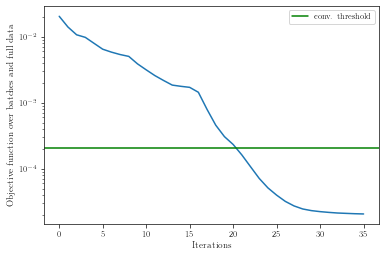

#################
	 Convergence criterion satisfied
	 Final objective function value 2.0565746246673187e-05 with # of initializations: 1 
 	 Total runtime: 51.09659481048584


In [59]:
bsize = 50   # The batch size on which the optimization is started

mGST_args = {'y': y, 'J': J, 'l': l, 'd': d, 'r': r, 'rK': 4, 'n_povm': n_povm, 'bsize': bsize, 
             'meas_samples': meas_samples, 'method': 'SFN', 'max_inits': 20, 'max_iter': 0, 
             'final_iter': 80, 'threshold_multiplier': 10, 'target_rel_prec': 1e-3}
ns = Namespace(**mGST_args)

results = []
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #The idle-X(pi/2)-Y(pi/2) model 
K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
X_t = np.einsum('ijkl,ijnm -> iknlm', K_t, K_t.conj()).reshape(d,r,r)  
K,X,E,rho,res_list = algorithm.run_mGST(ns.y,ns.J,ns.l,ns.d,ns.r,ns.rK, ns.n_povm, ns.bsize, ns.meas_samples, method = ns.method,
                 max_inits = ns.max_inits, max_iter = ns.max_iter, final_iter = ns.final_iter, threshold_multiplier = ns.threshold_multiplier, 
                 target_rel_prec = ns.target_rel_prec, init = [K_t, E_t, rho_t], testing = True)   
results.append([K,X,E,rho])

In [64]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
display(s_g), display(s_o)  

X_array, E_array, rho_array, df_g_array, df_o_array = bootstrap_errors(K_t,X_t,E_t,rho, mGST_args, 10, weights, gate_labels, std.target_model(), parametric = False)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,98601","0,07929","0,07972"
Rx(pi/2),"0,98179","0,05552","0,02844"
Ry(pi/2),"0,98457","0,04870","0,02401"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000021,0.003477,0.121432,0.086695,0.042103


Starting optimization...
 60%|██████    | 48/80 [01:20<00:53,  1.68s/it]
#################
	 Convergence criterion satisfied
	 Final objective function value 2.8797746227054167e-05 with # of initializations: 1 
 	 Total runtime: 80.85660219192505
Starting optimization...
 64%|██████▍   | 51/80 [01:24<00:47,  1.65s/it]
#################
	 Convergence criterion satisfied
	 Final objective function value 2.877814471123087e-05 with # of initializations: 1 
 	 Total runtime: 84.31326842308044
Starting optimization...
 59%|█████▉    | 47/80 [01:18<00:55,  1.68s/it]
#################
	 Convergence criterion satisfied
	 Final objective function value 2.8805111042202647e-05 with # of initializations: 1 
 	 Total runtime: 78.94806742668152
Starting optimization...
 61%|██████▏   | 49/80 [01:22<00:52,  1.68s/it]
#################
	 Convergence criterion satisfied
	 Final objective function value 2.8795367047745308e-05 with # of initializations: 1 
 	 Total runtime: 82.27350282669067
Starting opti

In [52]:
E_means = np.mean(E_array, axis = 0).real
E_stds = np.std(E_array, axis = 0).real
print(E_means)
print(E_stds)
# plt.errorbar(np.arange(4), E_means[0,:], yerr = E_stds[0,:])
# plt.show()

[[ 0.82392412 -0.03055432 -0.03347929  0.58854667]
 [ 0.59028945  0.03055432  0.03347929 -0.58854667]]
[[1.63523763e-04 1.24261676e-04 4.43933403e-05 1.57757465e-04]
 [1.63523763e-04 1.24261676e-04 4.43933403e-05 1.57757465e-04]]


### Save data

In [33]:
# ###################################### 
# filename = 'results-qubit1-fast'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[1,4],'phys. dimension':int(np.sqrt(r)), 'Sequence count': len(J), 
#               'J':J,'y':y,'threshold_multiplier': 30, 
#                      'target_rel_prec':1e-4}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis

### Rank 1

In [35]:
for i in range(1,4):
    filename = "results-qubit%i-fast"%i
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    results = b['results']

    # Performance metrics rank 1
    print("\n", filename)
    K,X,E,rho = results[0][:]
    J = b['parameters']['J']
    y = b['parameters']['y']

    weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
    gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
    X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)
    df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
    display(s_g), display(s_o)   


 results-qubit1-fast


,F_avg,Diamond distances
Id,"0,99663","0,07110"
Rx(pi/2),"0,99989","0,01279"
Ry(pi/2),"0,99992","0,01126"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000100,0.007530,0.121432,0.102657,0.101379



 results-qubit2-fast


,F_avg,Diamond distances
Id,"0,99124","0,11462"
Rx(pi/2),"0,99946","0,02845"
Ry(pi/2),"0,99945","0,02883"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000041,0.004969,0.122045,0.082250,0.083749



 results-qubit3-fast


,F_avg,Diamond distances
Id,"0,99947","0,02831"
Rx(pi/2),"0,99991","0,01181"
Ry(pi/2),"0,99990","0,01246"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000036,0.004868,0.053052,0.042236,0.055020


### Rank 4

In [37]:
for i in range(1,4):
    filename = "results-qubit%i-fast"%i
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    results = b['results']

    # Performance metrics rank 4
    print("\n", filename)
    K,X,E,rho = results[1][:]
    J = b['parameters']['J']
    y = b['parameters']['y']
    
    weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
    gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
    X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)
    df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, std.target_model(), gate_labels)
    display(s_g), display(s_o)   


 results-qubit1-fast


,F_avg,Diamond distances
Id,"0,98384","0,08122"
Rx(pi/2),"0,98337","0,05048"
Ry(pi/2),"0,98468","0,04709"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000017,0.003181,0.121432,0.088033,0.040173



 results-qubit2-fast


,F_avg,Diamond distances
Id,"0,98562","0,11697"
Rx(pi/2),"0,99092","0,04480"
Ry(pi/2),"0,99228","0,04175"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000018,0.003462,0.122045,0.077274,0.074279



 results-qubit3-fast


,F_avg,Diamond distances
Id,"0,99145","0,03491"
Rx(pi/2),"0,99247","0,02693"
Ry(pi/2),"0,99233","0,02613"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000017,0.003252,0.053052,0.036470,0.018129


### Gate plots


 results-qubit1-fast


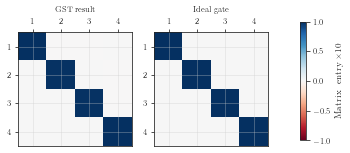

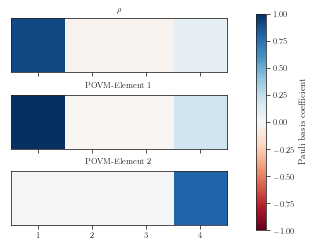

In [41]:
filename = "results-qubit1-fast"
with open(filename, 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

# Performance metrics rank 1
print("\n", filename)
K,X,E,rho = results[0][:]
J = b['parameters']['J']
y = b['parameters']['y']

weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, std.target_model(), weights)

plot_mat(X_opt[0], X_t[0])
plot_spam(rho_opt, E_opt)